# Data analyse NDW datasets

In dit notebook voeren wij een analyse uit op de datasets van het NDW om er achter te komen wat de verbanden tot de intensiteit zijn.

In [9]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree

We hebben een dataset opgevraagd bij het NDW. De opties vanuit het NDW zijn erg groot, maar aan de hand van de [data dictionary](https://docs.ndw.nu/en/handleidingen/DEXTER/intensiteiten-en-snelheden/) van het NDW hebben we als team bepaald dat de meeste kolommen niet relevant zijn voor ons. 

We hebben de locatie, tijd, intensiteit, snelheid, het aantal rijstroken en de VILD data gevraagd. De VILD data is locatie informatie waarmee we hopen dat we de locatie goed kunnen gaan hanteren en hier eventuele extra data mee kunnen vinden.

In [10]:
data = pd.read_csv("../data/intensiteit-snelheid-export-final.csv", low_memory=False)

## Data Understanding

Nu de dataset is ingeladen, onderzoeken we de kwaliteit en bruikbaarheid van de ruwe NDW-data.
We willen vooral weten:
- Hoe compleet de metingen zijn (minuten per uur),
- Hoeveel foutcodes (-1 snelheden) voorkomen,
- En of de patronen logisch zijn voor verkeer bij knooppunt Gouwe.

In [11]:

missing = data.isna().sum().sort_values(ascending=False)
invalid_speed = (data['gem_snelheid'] < 0).sum()
invalid_flow = (data['gem_intensiteit'] < 0).sum()

print("Ontbrekende waarden per kolom:")
display(missing)

print(f"\nAantal ongeldige snelheden (-1): {invalid_speed}")
print(f"Aantal ongeldige intensiteiten (-1): {invalid_flow}")

Ontbrekende waarden per kolom:


wegnummer_vild                       318240
traffic_flow_deviation_exclusions    318240
locatie_latitude_openlr              318240
locatie_longitude_openlr             318240
wegnaam_vild                         318240
technical_exclusion                  227524
gem_snelheid                          90716
gem_intensiteit                       90716
id_meetlocatie                            0
start_meetperiode                         0
eind_meetperiode                          0
ndw_index                                 0
totaal_aantal_rijstroken                  0
locatiecode_vild                          0
dtype: int64


Aantal ongeldige snelheden (-1): 12317
Aantal ongeldige intensiteiten (-1): 1710



**1. Ontbrekende waarden**
- De kolom  `traffic_flow_deviation_exclusions` bevat **318240 ontbrekende waarden**.  
  Deze kolom is volledig leeg en kan veilig worden verwijderd.
- De kolom `technical_exclusion` geeft aan  of er ergens een meetfout geweest is dit lijkt te kloppen met de hoeveelheid waardes in de kolommen `technical_exclusion` en `gem_snelheid`/`gem_intensiteit`
- De kolommen `locatie_latitude_openlr`, `locatie_longitude_openlr `, `wegnaam_vild` en `wegnummer_vild` bevatten **318240 ontbrekende waarden**.
  Dit betekent dat de VILD data niet goed is doorgegeven, maar de `locatiecode_vild` is wel aanwezig, dit lijkt genoeg te zijn voor later gebruik zoals koppelingen aan andere datasets.     
- Alle andere kolommen hebben **0 ontbrekende waarden**, wat betekent dat de dataset verder **compleet** is.

**2. Meetkolommen**
- Zowel `gem_snelheid` als `gem_intensiteit` bevatten wel een significant aantal missende waarden, maar we hebben genoeg data tot onze beschikking en kunnen ook meer opvragen  indien nodig.  

**3. Conclusie**

De dataset is **inhoudelijk compleet genoeg** en geschikt voor verdere analyse.  
De enige actie die we later ondernemen, is het verwijderen van de lege kolommen.  
Voor de rest kunnen we de waarden direct gebruiken voor onze eerste patroonverkenning.


In [12]:
data.describe()

,gem_intensiteit,gem_snelheid,totaal_aantal_rijstroken,locatiecode_vild,wegnummer_vild,wegnaam_vild,locatie_latitude_openlr,locatie_longitude_openlr,traffic_flow_deviation_exclusions
count,227524.000000,227524.000000,318240.000000,318240.000000,0.0,0.0,0.0,0.0,0.0
mean,564.452234,96.258658,2.835294,9849.247059,NaN,NaN,NaN,NaN,NaN
std,524.586059,30.967436,1.462048,5330.961935,NaN,NaN,NaN,NaN,NaN
min,-1.000000,-1.000000,1.000000,7269.000000,NaN,NaN,NaN,NaN,NaN
25%,58.000000,93.030000,2.000000,7271.000000,NaN,NaN,NaN,NaN,NaN
50%,403.000000,102.870000,3.000000,7272.000000,NaN,NaN,NaN,NaN,NaN
75%,1055.000000,114.390000,5.000000,8112.000000,NaN,NaN,NaN,NaN,NaN
max,2199.000000,231.000000,5.000000,22364.000000,NaN,NaN,NaN,NaN,NaN


De minimum waarden voor snelheid en intensiteit zijn beide -1. In de data dictionary is de vinden dat deze staan voor meetfouten. Dit is handige info om mee te nemen in de datacleaning. Deze waarden zijn cruciaal om te verwijderen, omdat ze verdeling scheef trekken en hierdoor de verbanden verstoren.

Ook is er eerder geconcludeerd dat de snelheid en intensiteit veel NaN waarden bevatten, deze converteren naar een geldige waarde kan de verdeling wederom scheef trekken. Hierdoor verwijderen we deze NaN waarden en vervangen we ze in de toekomst eventueel met nieuwe werkelijke waarden indien nodig.

In [13]:
data_f = data[(data["gem_snelheid"] != -1) & (data["gem_intensiteit"] != -1)].dropna(subset=["gem_snelheid", "gem_intensiteit"])

**Filtering voor analyse**

We werken met data_f, waar -1-metingen (foutcodes) en NaN in gem_snelheid en gem_intensiteit zijn verwijderd. Daarmee voorkomen we dat foutwaarden de verdelingen en verbanden vertekenen.


## Data exploratie

Om een inzicht te krijgen in de data is het belangrijk om te kijken naar de verdelingen van de meetwaarden. 

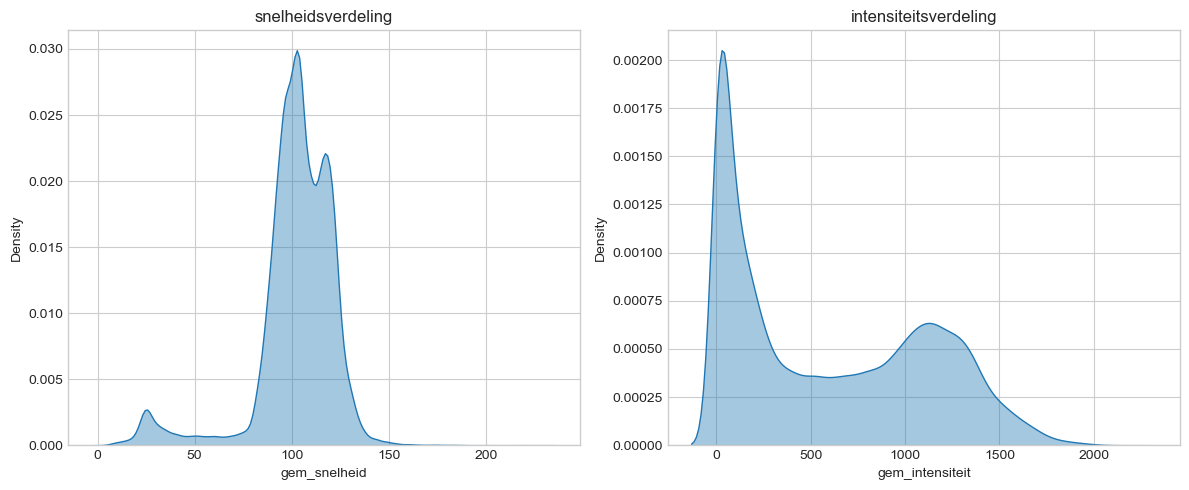

In [14]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: snelheidsverdeling
sns.kdeplot(data=data_f, x="gem_snelheid", fill=True, alpha=0.4, ax=axes[0])
axes[0].set_title("snelheidsverdeling")
axes[0].set_xlabel("gem_snelheid")


# Plot 2: intensiteitsverdeling
sns.kdeplot(data=data_f, x="gem_intensiteit", fill=True, alpha=0.4, ax=axes[1])
axes[1].set_title("intensiteitsverdeling")
axes[1].set_xlabel("gem_intensiteit")

plt.tight_layout()
plt.show()

De verdeling van de snelheid ziet er logisch uit. Het grootste deel rijdt tussen ongeveer 90 en 125 km per uur. Dat is logisch, want dit is de snelheidslimiet. Er valt wel op dat er ook waarden tussen de 0 en de 50 zitten, dit is aannamelijke een indicator voor file. 

De verdeling van de intensiteit ziet er algemeen ook logisch uit. De verdeling is wel heel rechtsscheef, opvallend is de hoeveelheid waarden tussen de 0 en 500, deze kunnen veel impact hebben op het model als dit doorrijdend verkeer is. Om deze reden plotten we dit in een scatterplot. 

<Axes: xlabel='gem_intensiteit', ylabel='gem_snelheid'>

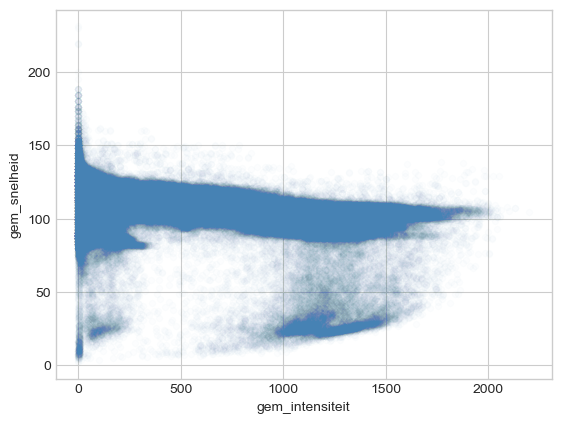

In [15]:

data_f.plot.scatter(x='gem_intensiteit', y='gem_snelheid', alpha=0.01, color='steelblue')



Deze scatterplot laat zien dat er een duidelijk verband is tussen verkeersintensiteit en gemiddelde snelheid. Bij lage intensiteit is de snelheid over het algemeen hoog en kan het verkeer vrij doorrijden, al varieert de snelheid wel. Naarmate de intensiteit toeneemt, begint de snelheid geleidelijk te dalen door drukte op de weg. Bij nog hogere intensiteit ontstaat er een tweede groep punten met veel lagere snelheden, wat wijst op filevorming. Dit betekent dat dezelfde intensiteit verschillende snelheden kan opleveren, afhankelijk van het moment en de verkeerssituatie. Daarom is intensiteit alleen niet voldoende om snelheid te voorspellen en moeten we ook rekening houden met tijd (bijv. spits, weekend) en locatiekenmerken.


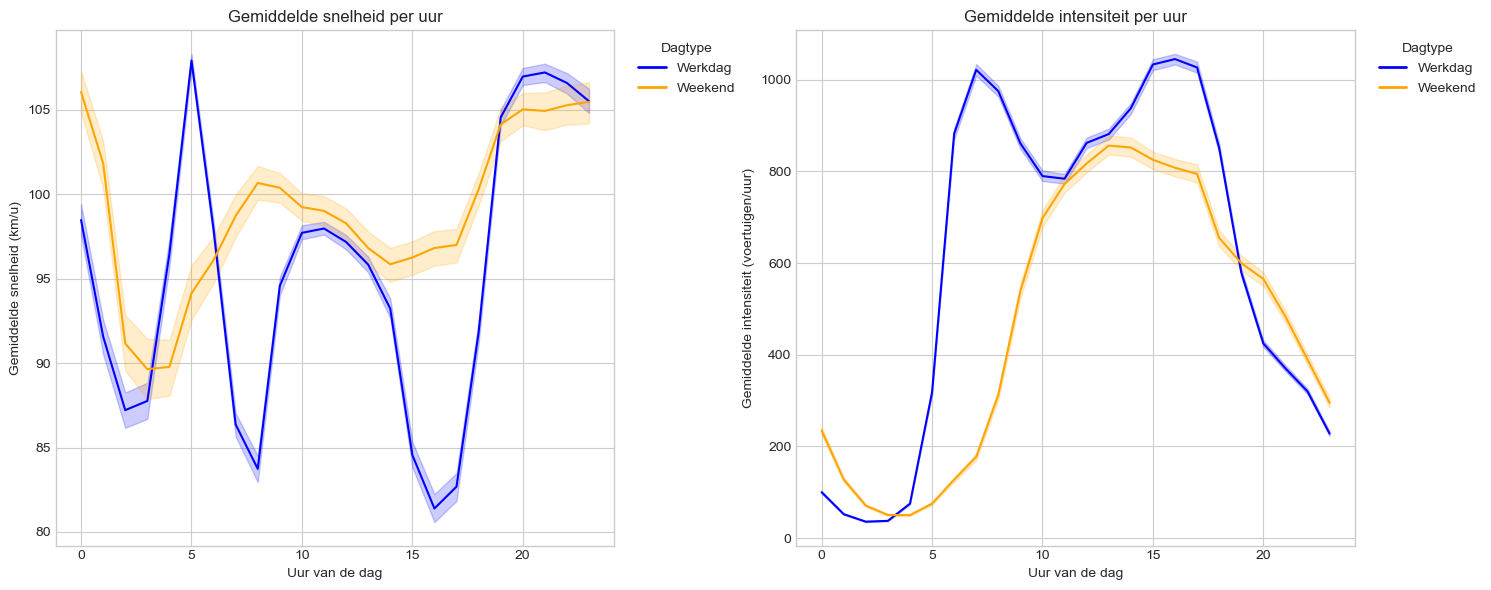

In [16]:
from matplotlib.lines import Line2D
# Tijd en uur
data['start_meetperiode'] = pd.to_datetime(data['start_meetperiode'])
data['hour'] = data['start_meetperiode'].dt.hour

data['is_weekend'] = data['start_meetperiode'].dt.dayofweek.isin([5, 6])
data['dagtype'] = pd.Categorical(
    ['Weekend' if w else 'Werkdag' for w in data['is_weekend']],
    categories=['Werkdag', 'Weekend'],
    ordered=True
)

# Kleuren
palette = {'Werkdag': 'blue', 'Weekend': 'orange'}

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

# Plot 1: Snelheid
sns.lineplot(
    data=data, x='hour', y='gem_snelheid',
    hue='dagtype', hue_order=['Werkdag', 'Weekend'],
    estimator='mean', palette=palette, ax=axes[0]
)
axes[0].set_title('Gemiddelde snelheid per uur')
axes[0].set_xlabel('Uur van de dag')
axes[0].set_ylabel('Gemiddelde snelheid (km/u)')

# Plot 2: Intensiteit
sns.lineplot(
    data=data, x='hour', y='gem_intensiteit',
    hue='dagtype', hue_order=['Werkdag', 'Weekend'],
    estimator='mean', palette=palette, ax=axes[1]
)
axes[1].set_title('Gemiddelde intensiteit per uur')
axes[1].set_xlabel('Uur van de dag')
axes[1].set_ylabel('Gemiddelde intensiteit (voertuigen/uur)')


custom_lines = [
    Line2D([0], [0], color=palette['Werkdag'], lw=2),
    Line2D([0], [0], color=palette['Weekend'], lw=2),
]
for ax in axes:
    ax.legend(custom_lines, ['Werkdag', 'Weekend'],
              title='Dagtype', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()


Deze grafieken laten zien hoe snelheid en intensiteit gedurende de dag verschillen tussen werkdagen en weekenddagen. Op werkdagen zien we duidelijke spitsmomenten rond ongeveer 8:00 en 17:00 uur: de intensiteit stijgt daar sterk en de gemiddelde snelheid daalt, wat wijst op druk verkeer en filevorming. In het weekend is dit patroon veel vlakker: er is minder intensiteit en de snelheid blijft hoger en stabieler, omdat er minder verkeersdruk is. Dit bevestigt dat verkeersgedrag sterk afhankelijk is van het dagtype. Voor het voorspellen van snelheid is het dus belangrijk om rekening te houden met tijdstippen en of het een werkdag of weekend betreft.


# Modeling


### Baseline model


Hier gebruiken we een baseline-voorspelling waarbij we voor elke waarde de gemiddelde snelheid uit de trainingsdata voorspellen. Dit model gebruikt dus geen informatie over de intensiteit of het tijdstip en dient vooral als referentiepunt.

In [17]:
X = data_f['gem_intensiteit']
y = data_f['gem_snelheid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:

y_pred_mean = np.full_like(y_test, fill_value=y_train.mean(), dtype=float)


rmse_mean = (root_mean_squared_error(y_test, y_pred_mean))

print(f"Baseline (gemiddelde voorspelling):")
print(f"  RMSE: {rmse_mean:.3f}")

Baseline (gemiddelde voorspelling):
  RMSE: 21.181


De RMSE van ongeveer 21 km/u betekent dat deze voorspelling gemiddeld 21 km/u afwijkt van de werkelijke snelheid. Elke voorspellingsmethode die we hierna proberen moet dus een lagere RMSE behalen om zinvol beter te zijn dan deze baseline.

Deze voorspelling komt overeen met de verwachtingen van de opdrachtgever

### Decision Tree Regressor

Hier trainen we een Decision Tree Regressor om de snelheid te voorspellen op basis van de intensiteit.


In [19]:
# sklearn needs 2d array to properly function
X_train_2d = X_train.values.reshape(-1, 1)
X_test_2d = X_test.values.reshape(-1, 1)


tree = DecisionTreeRegressor(max_depth=5)


tree.fit(X_train_2d, y_train)

y_pred_tree = tree.predict(X_test_2d)

rmse_tree = (root_mean_squared_error(y_test, y_pred_tree))

print("Decision Tree Regressor:")
print(f"  RMSE: {rmse_tree:.3f}")

Decision Tree Regressor:
  RMSE: 19.255


De RMSE komt uit op ongeveer 19.26, wat beter is dan de baseline van 21.Dit betekent dat het model daadwerkelijk nuttige informatie uit de intensiteit oppikt. De verbetering is echter nog beperkt. Dit bevestigt onze verwachting dat intensiteit alleen niet genoeg is om snelheid goed te voorspellen. Om betere resultaten te krijgen moeten we extra kenmerken toevoegen. Ook bestaat de mogelijkheid dat het RMSE erg kan verschillen per individueel geval, laten we dit bekijken in een grafiek.

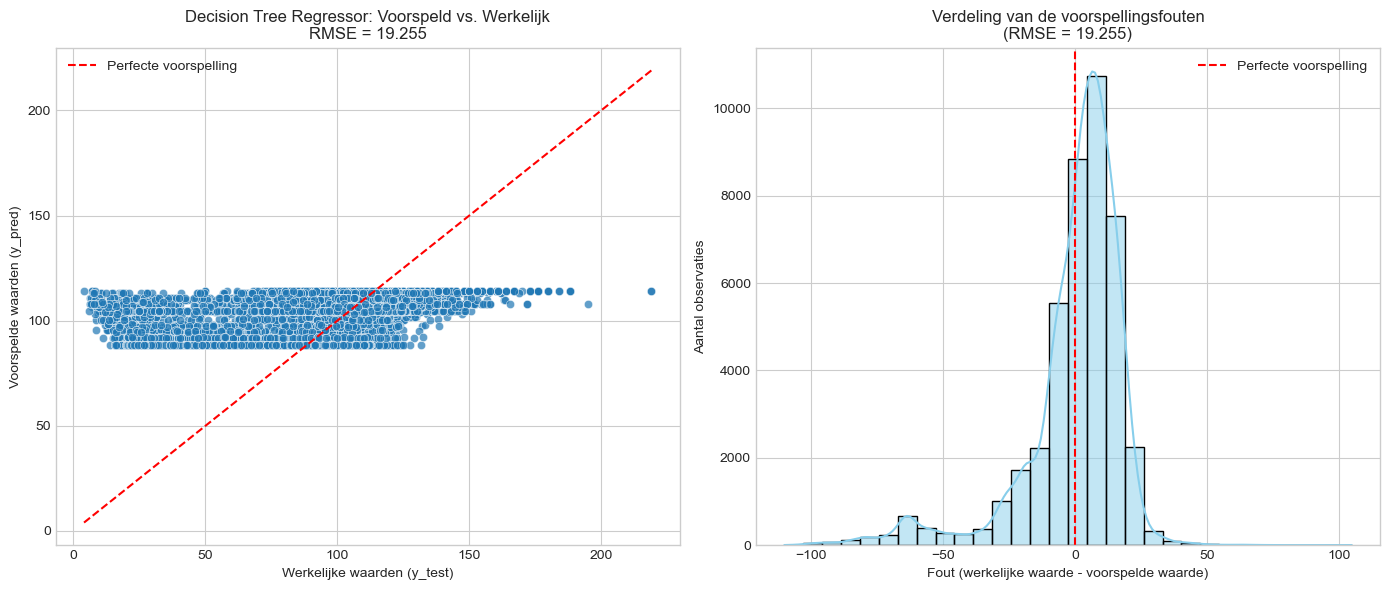

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Fouten berekenen
errors = y_test - y_pred_tree

# Subplots naast elkaar
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Voorspeld vs Werkelijk
sns.scatterplot(ax=axes[0], x=y_test, y=y_pred_tree, alpha=0.7)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfecte voorspelling")
axes[0].set_title(f"Decision Tree Regressor: Voorspeld vs. Werkelijk\nRMSE = {rmse_tree:.3f}")
axes[0].set_xlabel("Werkelijke waarden (y_test)")
axes[0].set_ylabel("Voorspelde waarden (y_pred)")
axes[0].legend()
axes[0].grid(True)

# Plot 2: Foutverdeling
sns.histplot(errors, bins=30, kde=True, color="skyblue", edgecolor="black", ax=axes[1])
axes[1].axvline(0, color='red', linestyle='--', label="Perfecte voorspelling")
axes[1].set_title(f"Verdeling van de voorspellingsfouten\n(RMSE = {rmse_tree:.3f})")
axes[1].set_xlabel("Fout (werkelijke waarde - voorspelde waarde)")
axes[1].set_ylabel("Aantal observaties")
axes[1].legend()
axes[1].grid(True)

# Layout optimaliseren
plt.tight_layout()
plt.show()


In de linker grafiek vergelijken we de voorspelde snelheid met de werkelijke snelheid. De rode stippellijn geeft aan waar de punten zouden liggen bij een perfecte voorspelling. We zien dat de voorspellingen van het model zich vooral concentreren rond een smalle band van ongeveer 90–110 km/u. Dit betekent dat het model de algemene gemiddelde snelheid wel herkent, maar niet goed in staat is om lage snelheden bij filevorming of hogere snelheden in rustige periodes te voorspellen.


De rechter grafiek laat zien hoeveel het model ernaast zit. We zien dat het model vooral te hoge snelheden voorspelt wanneer er file is. Dat komt doordat het model alleen intensiteit kent, maar niet weet of het ochtendspits, avondspits of weekend is. Daardoor voorspelt het vaak een gemiddelde waarde

### Knn Regressor

Hier trainen we een K-nearest neighbour Regressor om de snelheid te voorspellen op basis van de intensiteit.

In [21]:
from sklearn.neighbors import KNeighborsRegressor


X_train_2d = X_train.values.reshape(-1, 1)
X_test_2d = X_test.values.reshape(-1, 1)

# Probeer bijv. k = 5 buren (kan je later tunen)
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_2d, y_train)

y_pred_knn = knn.predict(X_test_2d)

rmse_knn = root_mean_squared_error(y_test, y_pred_knn)

print(f"KNN Regressor (k=5):")
print(f" RMSE: {rmse_knn:.3f}")


KNN Regressor (k=5):
 RMSE: 20.932


Net zoals het decision tree regressor model voorspeld het Knn model beter dan de baseline. Het RMSE licht wel lager dan bij de decision tree, mogelijk betekent dit dat de lagere waarden in dit model beter worden erkent.

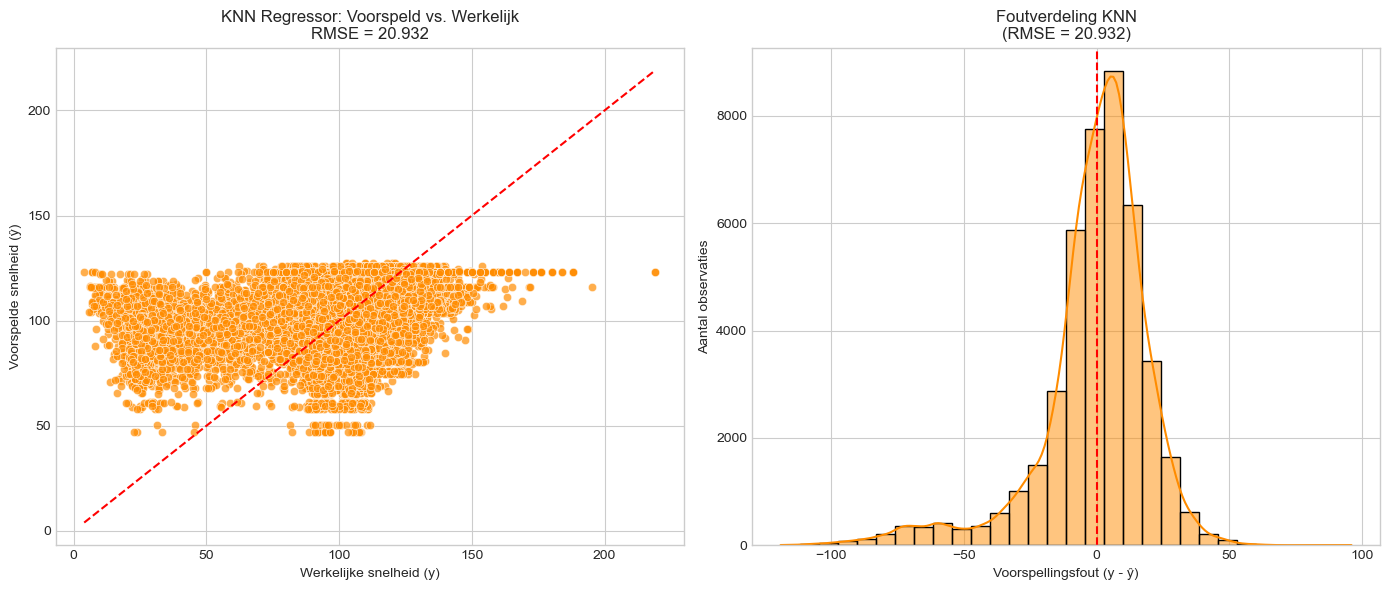

In [22]:
errors_knn = y_test - y_pred_knn
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Voorspeld vs Werkelijk
sns.scatterplot(ax=axes[0], x=y_test, y=y_pred_knn, alpha=0.7, color='darkorange')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0].set_title(f"KNN Regressor: Voorspeld vs. Werkelijk\nRMSE = {rmse_knn:.3f}")
axes[0].set_xlabel("Werkelijke snelheid (y)")
axes[0].set_ylabel("Voorspelde snelheid (ŷ)")
axes[0].grid(True)

# Plot 2: Foutverdeling
sns.histplot(errors_knn, bins=30, kde=True, color="darkorange", edgecolor="black", ax=axes[1])
axes[1].axvline(0, color='red', linestyle='--')
axes[1].set_title(f"Foutverdeling KNN\n(RMSE = {rmse_knn:.3f})")
axes[1].set_xlabel("Voorspellingsfout (y - ŷ)")
axes[1].set_ylabel("Aantal observaties")
axes[1].grid(True)

# Layout netjes maken
plt.tight_layout()
plt.show()

Het KNN-model laat zien dat de gemiddelde intensiteit alleen niet genoeg informatie bevat om snelheidsdalingen (en dus filevorming) goed te voorspellen. Het model voorspelt vooral waarden rond de gemiddelde snelheid en mist daardoor juist de belangrijke extreme situaties waarin de snelheid sterk daalt. Voor het detecteren en voorspellen van files zijn dus extra variabelen nodig, zoals:

- Tijdstip en dagtype (spitsuren vs. weekend)
- Locatiekenmerken (bijvoorbeeld op- en afritten)

Het model bevestigt dus dat er meer context nodig is om filevorming betrouwbaar te voorspellen. Dit sluit aan bij onze vervolgstap om VILD- en WKD-data te koppelen, zodat we locatie- en wegkenmerken kunnen meenemen in het model.

### Knn vs Decision tree regressor

Laten we bekijken hoe de modellen presteren als je ze met elkaar vergelijkt.


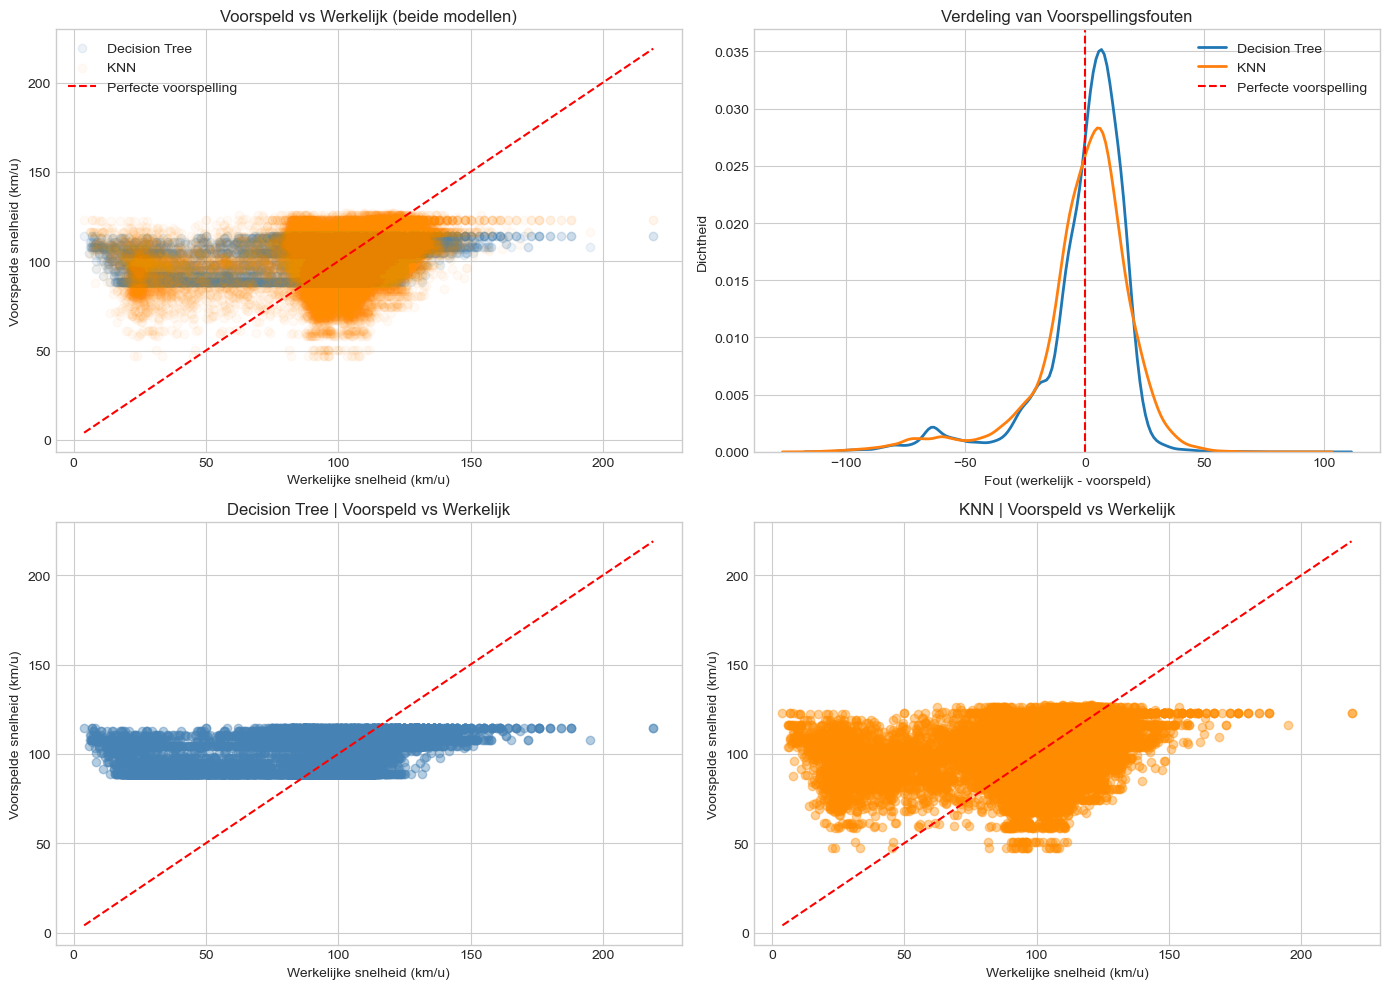

In [23]:
y_true = pd.Series(y_test, name="y_true")
y_dt   = pd.Series(y_pred_tree, index=y_true.index, name="Decision Tree")
y_knn  = pd.Series(y_pred_knn,  index=y_true.index, name="KNN")

err_dt  = (y_true - y_dt).rename("Decision Tree")
err_knn = (y_true - y_knn).rename("KNN")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1) Combined Voorspeld vs Werkelijk
axes[0,0].scatter(y_true, y_dt, alpha=0.1, label="Decision Tree", color="steelblue")
axes[0,0].scatter(y_true, y_knn, alpha=0.04, label="KNN", color="darkorange")
axes[0,0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--", label="Perfecte voorspelling")
axes[0,0].set_title("Voorspeld vs Werkelijk (beide modellen)")
axes[0,0].set_xlabel("Werkelijke snelheid (km/u)")
axes[0,0].set_ylabel("Voorspelde snelheid (km/u)")
axes[0,0].legend()
axes[0,0].grid(True)

# 2) Foutverdeling
sns.kdeplot(err_dt, ax=axes[0,1], linewidth=2, label="Decision Tree")
sns.kdeplot(err_knn, ax=axes[0,1], linewidth=2, label="KNN")
axes[0,1].axvline(0, color="red", linestyle="--", label="Perfecte voorspelling")
axes[0,1].set_title("Verdeling van Voorspellingsfouten")
axes[0,1].set_xlabel("Fout (werkelijk - voorspeld)")
axes[0,1].set_ylabel("Dichtheid")
axes[0,1].legend()
axes[0,1].grid(True)

# 3) Decision Tree afzonderlijk scatter
axes[1,0].scatter(y_true, y_dt, alpha=0.4, color="steelblue")
axes[1,0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--")
axes[1,0].set_title("Decision Tree | Voorspeld vs Werkelijk")
axes[1,0].set_xlabel("Werkelijke snelheid (km/u)")
axes[1,0].set_ylabel("Voorspelde snelheid (km/u)")
axes[1,0].grid(True)

# 4) KNN afzonderlijk scatter
axes[1,1].scatter(y_true, y_knn, alpha=0.4, color="darkorange")
axes[1,1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--")
axes[1,1].set_title("KNN | Voorspeld vs Werkelijk")
axes[1,1].set_xlabel("Werkelijke snelheid (km/u)")
axes[1,1].set_ylabel("Voorspelde snelheid (km/u)")
axes[1,1].grid(True)

plt.tight_layout()
plt.show()


Uit de visualisaties blijkt dat Decision Tree iets beter presteert dan het KNN-Model, de foutverdeling van de decision tree ligt iets dichter bij de 0 wat betekent dat de voorspelling gemiddeld minder ver van de werkelijke snelheid af zit.
Het Knn model voorspeld lagere waarden echter wel beter, te zien aan dat de voorspellingen veel lager liggen dan de decision tree.

## Conclusie en mogelijke vervolgstappen

Uit dit onderzoek blijkt dat `gem_intensiteit` op zichzelf niet genoeg informatie bevat om snelheid of filevorming goed te voorspellen. Zowel de Decision Tree als het KNN-model verbeteren de baseline maar beperkt en hebben moeite met het herkennen van lagere snelheden tijdens files. Dit komt vooral doordat de dataset momenteel veel meer metingen bevat van doorstromend verkeer dan van files, en omdat er weinig contextkenmerken zijn opgenomen.

### Vervolgstappen

1. **Dataset balanceren**
   - Er zijn veel meer situaties met doorrijdend verkeer dan met file. Door filemomenten relatief te versterken (bijv. selecteren of oversamplen) kan het model beter leren waar de omslag plaatsvindt.

2. **Meer relevante features toevoegen**
   - Tijdstip (uur van de dag, spits vs dal)
   - Dagtype (werkdag/weekend)
   - Wegkenmerken via **VILD** en **WKD** (bijv. aantal rijstroken, ligging bij oprit/afrit)

3. **Modelstrategie verfijnen**
   - Mogelijk is een **classificatiemodel** (“file” vs “geen file”) geschikter als eerste stap dan regressie op snelheid.
   - Het idee voor een **piecewise of lineaire decision tree** nemen we mee naar volgende sprint, omdat dit model beter kan omgaan met het omslagpunt (cut-off gedrag).
   - het idee voor een **predator prey model** nemen we mee naar de volgende sprint, mogelijk kan dit model omgaan met cyclisch gedrag als dit daadwerkelijk aanwezig is.

### Vragen voor de opdrachtgever

- Wilt u dat wij in eerste instantie focussen op **filedetectie** (classificatie) of op **voorspellen van exacte snelheid** (regressie)?
- In hoeverre is het wenselijk dat we **WKD-locatiekenmerken integreren** (dit vraagt extra koppeling en datavoorbewerking)?
- Hoe willen jullie dat wij omgaan met de scheve verdeling tussen file en doorstroming (bijv. balans forceren of natuurlijke verhouding behouden)?
